# Recommender System

### What this project does
### What this project doesn't do

In [ ]:
# For working on Google Colab
# !curl -O http://files.grouplens.org/datasets/movielens/ml-100k.zip
# !curl -O https://files.grouplens.org/datasets/movielens/ml-10m.zip
# !unzip ml-10m.zip
# !cd ml-10M100K/

In [4]:
import numpy as np
import pandas as pd
import scipy.sparse as sparse
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
from tqdm.notebook import trange, tqdm
import ipywidgets
!jupyter nbextension enable --py widgetsnbextension
%matplotlib inline

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


Until now, I've encountered two types of data objects in the Pandas library—DataFrames and Series, and here is a [Scaler Topics article on core components of Pandas](https://www.scaler.com/topics/pandas/core-components-of-pandas/), confirming that these two are the important ones (for single-dimensional, and two-dimensional data respectively), apart from a third object type, `Panel` (for three-dimensional data).

Here's a micro-article attempting to list the organisation of files in Pandas' architecture: [Discover Pandas Library Architecture – File Hierarchy in Pandas](https://data-flair.training/blogs/pandas-library-architecture/)


In [7]:
ratings_df = pd.read_csv("./ml-latest-small/ratings.csv")
# ratings_df = pd.read_csv("./ml-10M100K/ratings.dat", delimiter='::', names=['userId', 'movieId', 'rating', 'timestamp'])
# ratings_df = pd.read_csv("./anime-ratings-matrix-factorization-v-10/anime ratings dataset/rating.csv")

In [8]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [34]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [10]:
# num_movies = pd.DataFrame(ratings_df['movieId'].unique()).count().values[0]       #this is a tad more convoluted way
# num_users = pd.DataFrame(ratings_df['userId'].unique()).count().values[0]
num_movies = ratings_df['movieId'].unique().shape[0]                                #better way
num_users = ratings_df['userId'].unique().shape[0]
print(f"There are {num_movies} movies and {num_users} users in the dataset")

There are 9724 movies and 610 users in the dataset


In [36]:
print(f"There are {ratings_df.loc[ratings_df.userId > num_users].userId.unique().shape[0]} user IDs exceeding {num_users}.")
print(f"There are {ratings_df.loc[ratings_df.movieId > num_movies].movieId.unique().shape[0]} movie IDs exceeding {num_movies}.")

There are 0 user IDs exceeding 610.
There are 4334 movie IDs exceeding 9724.


It seems that the user IDs are contiguous, while the move IDs are not. We might have to consider making them contiguous.

In [37]:
ratings_df.describe().T

,count,mean,std,min,25%,50%,75%,max
userId,100836.0,3.261276e+02,1.826185e+02,1.0,1.770000e+02,3.250000e+02,4.770000e+02,6.100000e+02
movieId,100836.0,1.943530e+04,3.553099e+04,1.0,1.199000e+03,2.991000e+03,8.122000e+03,1.936090e+05
rating,100836.0,3.501557e+00,1.042529e+00,0.5,3.000000e+00,3.500000e+00,4.000000e+00,5.000000e+00
timestamp,100836.0,1.205946e+09,2.162610e+08,828124615.0,1.019124e+09,1.186087e+09,1.435994e+09,1.537799e+09


In [38]:
pd.Series.value_counts(ratings_df['rating']).to_frame().T

rating,4.0,3.0,5.0,3.5,4.5,2.0,2.5,1.0,1.5,0.5
count,26818,20047,13211,13136,8551,7551,5550,2811,1791,1370


In [39]:
# plt.hist(ratings_df['rating'], bins=[(i-1)/2 for i in range(0, 12)])
# plt.hist(ratings_df['rating'], bins=[i-0.5 for i in range(-1,12)])  #for anime ratings dataset

In [40]:
print( ratings_df.isna().sum() , "\n")
print( type(ratings_df.isna().sum()) )

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64 

<class 'pandas.core.series.Series'>


In [41]:
print( len(ratings_df.duplicated(subset=['userId', 'movieId'])) )
len(np.where( ratings_df.duplicated(subset=['userId', 'movieId']) == False )[0])

100836


100836

There don't seem to be any duplicates *shruggie

In [42]:
toy = np.zeros((3,4))
toy[0,1] = 1
toy[2,3] = 2
toy

array([[0., 1., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 2.]])

In [43]:
toy_csc = sparse.csc_matrix(toy)
print( toy_csc.data )
print( toy_csc.nnz )  # nnz => no. of non-zero (entries)
print( toy_csc.nonzero() )

[1. 2.]
2
(array([0, 2], dtype=int32), array([1, 3], dtype=int32))


In [44]:
toy_csc.power(2).todense()

matrix([[0., 1., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 4.]])

In [45]:
############################################################################
## This was an attempt to write a general function to make IDs contiguous ##
############################################################################

# def make_id_contiguous(df:pd.DataFrame, id:str):
#        old_new_id = np.zeros(df[id].max()+1)
#        for new_id, old_id in enumerate(df[id].unique()):
#               old_new_id[old_id] = new_id
              
#        import re
#        RE_WORDS = re.compile(r'''
#                      # Find words in a string. Order matters!
#                      [A-Z]+(?=[A-Z][a-z]) |  # All upper case before a capitalized word
#                      [A-Z]?[a-z]+ |  # Capitalized words / all lower case
#                      [A-Z]+ |  # All upper case
#                      \d+  # Numbers
#                      ''', re.VERBOSE)
#        id_split = RE_WORDS.findall(id)
#        print(id_split)
#        print(np.where(id_split == 'Id'))
#        # id_split[np.where(id_split == 'Id')] = 'newId'
#        new_id_name = "".join(i for i in id_split)

#        df[new_id_name] = old_new_id[df[id]]
#        df = df.astype({new_id_name: 'int64'})
#        print( df.head(), "\n" )
#        return old_new_id

# make_id_contiguous(ratings_df, 'movieId')

In [11]:
user_old_new_id = np.zeros(ratings_df["userId"].max()+1)
for new_id, old_id in enumerate(ratings_df['userId'].unique()):
       user_old_new_id[old_id] = new_id
       
ratings_df['userNewId'] = user_old_new_id[ratings_df['userId']]
ratings_df = ratings_df.astype({'userNewId': 'int64'})

print( ratings_df.head(), "\n" )
# now just to check that we did it correctly, a movieId should be mapped to the same movieNewId
print( ratings_df.loc[ratings_df.userId == 156][['userId', 'userNewId']], "\n" ) 
print(f"There are {num_users} users and correspondingly {max(user_old_new_id)+1} contiguous user IDs now")

   userId  movieId  rating  timestamp  userNewId
0       1        1     4.0  964982703          0
1       1        3     4.0  964981247          0
2       1        6     4.0  964982224          0
3       1       47     5.0  964983815          0
4       1       50     5.0  964982931          0 

       userId  userNewId
22684     156        155
22685     156        155
22686     156        155
22687     156        155
22688     156        155
...       ...        ...
23077     156        155
23078     156        155
23079     156        155
23080     156        155
23081     156        155

[398 rows x 2 columns] 

There are 610 users and correspondingly 610.0 contiguous user IDs now


In [13]:
movie_old_new_id = np.zeros(ratings_df["movieId"].max()+1)
for new_id, old_id in enumerate(ratings_df['movieId'].unique()):
       movie_old_new_id[old_id] = new_id
       
ratings_df['movieNewId'] = movie_old_new_id[ratings_df['movieId']]
ratings_df = ratings_df.astype({'movieNewId': 'int64'})

print( ratings_df.head(), "\n" )
# now just to check that we did it correctly, a movieId should be mapped to the same movieNewId
print( ratings_df.loc[ratings_df.movieId == 156][['movieId', 'movieNewId']], "\n" ) 
print(f"There are {num_movies} movies and correspondingly {max(movie_old_new_id)+1} contiguous movie IDs now")

   userId  movieId  rating  timestamp  userNewId  movieNewId
0       1        1     4.0  964982703          0           0
1       1        3     4.0  964981247          0           1
2       1        6     4.0  964982224          0           2
3       1       47     5.0  964983815          0           3
4       1       50     5.0  964982931          0           4 

       movieId  movieNewId
17007      156        4463
96137      156        4463
97391      156        4463 

There are 9724 movies and correspondingly 9724.0 contiguous movie IDs now


In [14]:
train_df, test_df = train_test_split(ratings_df, test_size=0.2, random_state=42)  #setting random_state ensures consistent splitting every time

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
print(train_df)
print(test_df)
print( np.shape(train_df), np.shape(test_df) )

       userId  movieId  rating   timestamp  userNewId  movieNewId
0         509     7347     3.0  1435994597        508        4285
1         326    71462     4.0  1322252335        325        5629
2          57     2115     3.0   965798155         56         134
3         610     1127     4.0  1479544102        609          66
4         462     2409     2.0  1174438249        461        1172
...       ...      ...     ...         ...        ...         ...
80663      42     4005     4.0   996259059         41        1873
80664     364      141     4.0   869443367        363         524
80665     480     6867     4.0  1179163171        479        2240
80666       6      981     3.0   845556567          5         712
80667     103     6711     5.0  1431957425        102        2046

[80668 rows x 6 columns]
       userId  movieId  rating   timestamp  userNewId  movieNewId
0         432    77866     4.5  1335139641        431        4730
1         288      474     3.0   978465565        

Since we've chosen to make the movie IDs contiguous by mapping them to new ones, splitting the DataFrame makes creating smaller-dimensional matrix representations of the training or test sets difficult, because, say, the indices chosen in the training set can still lie out of bounds of its smaller matrix's size (similar logic holds for the test set).

Instead, let's just work with the full ratings matrix, with the test entries zeroed out in the training matrix (and vice versa), which wouldn't be a bother to the memory anyway because we're using a sparse representation!

In [15]:
train = sparse.csc_matrix( (train_df['rating'].values, (train_df['userNewId'].values, train_df['movieNewId'].values)),\
                                 shape=(num_users+1, num_movies+1) )
test = sparse.csc_matrix(  (test_df['rating'].values, (test_df['userNewId'].values, test_df['movieNewId'].values)),\
                                 shape=(num_users+1, num_movies+1))

print(f"There are {train.nnz} & {test.nnz} non-zero elements in the train and test sparse matrices respectively.\n", test.shape[0],train.shape[1] )
# train.to_dense()
# print( train )

There are 80668 & 20168 non-zero elements in the train and test sparse matrices respectively.
 611 9725


Lemme check once that the test and train matrix elements are indeed mutually exclusive (zero, non-zero in their matrices respectively).

The cell below seems to show all's good

In [50]:
for i in zip(test.nonzero()[0], test.nonzero()[1]):
       if( train[i[0],i[1]] != 0 ):
              print("Hah!")
for i in zip(train.nonzero()[0], train.nonzero()[1]):
       if( test[i[0],i[1]] != 0 ):
              print("Hah!")

In [51]:
# print( np.sort(train_df['userId'].values) )
# print( mf.p_nnz_idx, "\n" )

# print( np.sort(train_df['movieNewId'].values) )
# print( np.sort(mf.q_nnz_idx ) )
# print( np.sort(train_df['userId'].values) == mf.p_nnz_idx )
# print( np.sort(train_df['movieNewId'].values) == np.sort(mf.q_nnz_idx), "\n" )

# print( np.where( np.sort(train_df['userId'].values) != train.nonzero()[0]) )
# print( np.where( np.sort(train_df['movieNewId'].values) != np.sort( train.nonzero()[1]) ) )
# print( np.where( np.sort(train_df['movieNewId'].values) != np.sort(mf.q_nnz_idx)) )


Hmmm, so the row indices seem to be all good, ~~but the column indices are playing foul.~~ as do the column indices.

Wasted quite the time pursuing this!

We have used the list `train_df['movieNewId'].values` as the column indices needed to generate R, but upon querying back these column indices, ~~they're coming out wrong!~~
Previously, I wasn ony sorting the `train_df['movieNewId'].values` list, and not the list `mf.q_nnz_idx` for comparison. Upon sorting both, they indeed come out to be the same.
***

## Matrix Factorisation Class
Below, I furnish a Matrix Factorisation Python class that implements:
- gradient descent
- (pending) gradient descent with user and item biases
- (pending) sgd
- (pending) ALS
to learn the embeddings.

My current implementation of gradient descent considers the loss function for explicit ratings, i.e. solely over observed values.
Still need to implement the Koren et al. approach capturing implicit ratings from the entire matrix.

The regularised loss I've used for explicit ratings: $$L(R, P, Q) = \frac{1}{N}\underset{(i,j):r_{ui}≠Nan}{\sum} (r_{ui} - p_u^T\cdot q_i)^2 + \lambda(\sum_u{||p_u||^2} + \sum_i{||q_i||^2})$$
It's a squared error (SE) loss function with regularisation terms. I wonder how using the Mean SE or RMSE would change the behaviour. ~~Conceptually, it shouldn't..~~ Oh how pathetically wrong I was! Not providing the required normalisation on the gradient terms just blew the cost up! I wonder why not providing the normalisation to the gradient calculation blows up the cost. The two seem unrelated, except, not!

Still need to add the user and item bias terms to SGD and GD

I could provide an option for choosing to provide explicit or implicit data. That way, when one chooses explicit data, I can internally use either of sgd or gd as default (still need to choose which), and when one chooses implicit data, I can choose either ALS or CG.

In [ ]:
class MatrixFactorisation():
       def __init__(self, R:sparse.csc_matrix, k:int, verbose:bool=False ):
              self.R = R           # R is the "ratings" matrix to be factorised
              self.k = k           # hyperparameter k is the number of latent factors desired in the factorised embeddings
              self.m, self.n = R.shape
              self.P = np.random.rand(self.m, k)        # initialising the first factor embedding (of "users")
              self.Q = np.random.rand(self.n, k)        # initialising the second factor embedding (of "items")
              self.p_nnz_idx, self.q_nnz_idx = R.nonzero()        # row and col indices in R matrix respectively, of non-zero elements
              self.train_mse_at_epochs = []
              self.test_mse_at_epochs = []
              self.verbose = verbose
              self.verbose_epoch_intvl = 50

       def __predict_observed(self):
              R_predicted = np.sum( np.multiply(self.P[self.p_nnz_idx], self.Q[self.q_nnz_idx]), axis=1 )       #calculating the products only for the nonzero "observed" rating entries
              R_predicted = sparse.csc_matrix( (R_predicted, (self.p_nnz_idx, self.q_nnz_idx)), shape=(self.m,self.n))              
              # R_predicted = self.P @ self.Q.T
              # R_predicted = sparse.csc_matrix(R_predicted)
              return R_predicted

       # def error

       def gradients(self, R, _lambda):
              """
              returns gradients w.r.t the elements of the embedding vectors, along with the errors
              """
              R_predicted = self.__predict_observed()
              error = R - R_predicted
              norm_factor = -2 / self.R.shape[0]  #this factor is crucial! Can't be 1 (i.e. we can't leave the gradients unnormalised, else cost diverges!)
              grad_P = norm_factor * (error*self.Q) + 2*(_lambda*self.P)
              grad_Q = norm_factor * (error.T*self.P) + 2*(_lambda*self.Q)
              return grad_P, grad_Q, error

       def gradient_descent(self, iterations=2000, learning_rate = 0.3, _lambda=0.0002, validation:sparse.csc_matrix=None, verbose=False):
              """
              Returns user and item embedding matrices by learning their entries via gradient descent.

              Optionally provide a sparse matrix with validation data, to compute the validation performance (measured by mse) over time
              """
              self.verbose = verbose

              grad_P, grad_Q, error = self.gradients(self.R, _lambda)
              v_P = grad_P
              v_Q = grad_Q
              beta = 0.8    # momentum constant
              train_mse = error.power(2).sum()/self.R.shape[0]
              # print("train mse:", train_mse)
              self.train_mse_at_epochs.append( [1, train_mse] )
              for i in range(iterations):
                     grad_P, grad_Q, error = self.gradients(self.R, _lambda)
                     v_P = beta*v_P + (1-beta)*grad_P   
                     v_Q = beta*v_Q + (1-beta)*grad_Q
                     self.P = self.P - learning_rate*v_P       # Grad Desc update rule
                     self.Q = self.Q - learning_rate*v_Q       # Grad Desc update rule
                     # print("train mse:", error.power(2).sum()/self.R.shape[0] )  #print mse at each iteration
                     if(not (i+1)%self.verbose_epoch_intvl):
                            self.save_train_mse(i, error)
                            self.save_test_mse(i, validation=validation)
              return self.P, self.Q

       def save_train_mse(self, i, error):
              train_mse = error.power(2).sum()/self.R.shape[0]
              self.train_mse_at_epochs.append( [i+1, train_mse])
              if(self.verbose):
                     print("\niteration/epoch", i+1, ":")
                     print("train mse:", train_mse)

       def save_test_mse(self, i, validation=None):
              if(validation != None):
                     valdn_p_nnz_idx, valdn_q_nnz_idx = validation.nonzero()
                     valdn_predicted = np.sum( np.multiply(self.P[valdn_p_nnz_idx], self.Q[valdn_q_nnz_idx]), axis=1 )       #calculating the products only for the nonzero "observed" rating entries
                     valdn_predicted = sparse.csc_matrix( (valdn_predicted, (valdn_p_nnz_idx, valdn_q_nnz_idx)), shape=(self.m,self.n))
                     valdn_error = validation - valdn_predicted
                     test_mse = valdn_error.power(2).sum()/self.R.shape[0]
                     self.test_mse_at_epochs.append([i+1, test_mse])
                     if(self.verbose):
                            print("iteration", i+1, ":")
                            print("test mse:", test_mse)

       def sgd(self, epochs=30, learning_rate=0.003, _lambda=0.0002, verbose=False):
              self.verbose = verbose
              beta = 0.8

              num_samples = len(self.p_nnz_idx)
              training_indices = np.arange(num_samples)
              # I couldn't have shuffled the array p_nnz_idx itself, cuz that would require shuffling q_nnx_idx in a corresponding manner

              # with tqdm(total=100) as prog_bar:
              for epoch in tqdm(range(epochs), desc="SGD epoch completion: "):
                     np.random.shuffle(training_indices)       #stochasticity must be ensured properly!
                     for i in tqdm(training_indices, desc=f"Finishing epoch: "):         #We need to update all users and items at least once in each iteration
                            p_idx = self.p_nnz_idx[i]
                            q_idx = self.q_nnz_idx[i]

                            R_ij = self.R[p_idx, q_idx]
                            P_i = self.P[p_idx]
                            Q_j = self.Q[q_idx]

                            R_predicted_ij = P_i.dot(Q_j.T)
                            error_ij = R_ij - R_predicted_ij
                            grad_P_i = -2*(error_ij * Q_j) + 2*(_lambda * self.P[p_idx])
                            grad_Q_j = -2*(error_ij * P_i) + 2*(_lambda * self.Q[q_idx])

                            v_P_i = beta*v_P_i + (1-beta)*grad_P_i if epoch!=0 else grad_P_i
                            v_Q_j = beta*v_Q_j + (1-beta)*grad_Q_j if epoch!=0 else grad_Q_j
       
                            self.P[p_idx] -= learning_rate * v_P_i
                            self.Q[q_idx] -= learning_rate * v_Q_j
                            # self.P[p_idx] -= learning_rate* grad_P_i
                            # self.Q[q_idx] -= learning_rate* grad_Q_j

                     if(not (epoch+1)%(self.verbose_epoch_intvl/10)):
                            R_predicted = np.sum( np.multiply(self.P[self.p_nnz_idx], self.Q[self.q_nnz_idx]), axis=1 )       #calculating the products only for the nonzero "observed" rating entries
                            R_predicted = sparse.csc_matrix( (R_predicted, (self.p_nnz_idx, self.q_nnz_idx)), shape=(self.m,self.n))
                            error = self.R - R_predicted
                            self.save_train_mse(epoch, error)
                            # self.save_test_mse(i, validation=validation)
              return self.P, self.Q

       def als(self, epochs=10, alpha=40, _lambda=10, verbose=False):
              ## should I be making the following tradeoff for precomputed memory, to speed up implementation?
              # Cp_array = []
              # Cq_array = []
              # for p in range(self.m):
              #        C_p = sparse.diags(self.R[p].toarray(), [0])
              #        Cp_array.append(C_p)
              # for q in range(self.n):
              #        C_q = sparse.diags(self.R[q].toarray(), [0])
              #        Cq_array.append(C_q)
              self.verbose = verbose
              lambda_eye = _lambda * sparse.eye(self.k)

              # the memory for this loop can further be optimised by eliminating the two similar loops with appropriate conditioning
              for i in tqdm(range(epochs), desc="ALS iterations completion: "):
                     Q = sparse.csc_matrix(self.Q)
                     QTQ = Q.T.dot(Q)         #precomputation of Q.T.dot(Q) for all elements of P
                     for p in tqdm(range(self.m), desc="Solving for P: ", leave=True):
                            R_p = self.R[p].toarray()
                            CpI = sparse.diags(alpha * R_p, [0])      #This acts as the (C^u - I) matrix in literature
                            QTCpIQ = Q.T.dot(CpI).dot(Q)
                            A = (QTQ + QTCpIQ) + lambda_eye

                            phi = R_p.copy()
                            phi[np.where(phi != 0)] = 1.0
                            b = Q.T.dot(CpI + sparse.eye(self.n)).dot(sparse.csc_matrix(phi).T)       # why the last transpose on phi though?

                            # P[p] = sparse.linalg.spsolve(A, b)
                            self.P[p] = sparse.linalg.spsolve(A, b)
                     
                     P = sparse.csc_matrix(self.P)
                     PTP = P.T.dot(P)         #precomputation of P.T.dot(P) for all elements of Q
                     for q in tqdm(range(self.n), desc="Solving for Q: "):
                            R_q = self.R[:,q].T.toarray()
                            CqI = sparse.diags(alpha * R_q, [0])      #This acts as the (C^u - I) matrix in literature
                            PTCqIP = P.T.dot(CqI).dot(P)
                            A = (PTP + PTCqIP) + lambda_eye

                            phi = R_q.copy()
                            phi[np.where(phi != 0)] = 1.0
                            b = P.T.dot(CqI + sparse.eye(self.m)).dot(sparse.csc_matrix(phi).T)       # why the last transpose on phi though?

                            # Q[q] = sparse.linalg.spsolve(A, b)
                            self.Q[q] = sparse.linalg.spsolve(A, b)

                     # Phi_predicted = np.sum( np.multiply(P[self.p_nnz_idx], Q[self.q_nnz_idx]), axis=1 )       #calculating the products only for the nonzero "observed" rating entries
                     # Phi_predicted = sparse.csc_matrix( (Phi_predicted, (self.p_nnz_idx, self.q_nnz_idx)), shape=(self.m,self.n))
                     # Phi = self.R
                     # Phi[Phi.nonzero()] = 1.0
                     # error = Phi - Phi_predicted
                     # self.save_train_mse(i, error)
              self.P = P
              self.Q = Q
              return self.P, self.Q

       def plot_learning_curve(self, validation=None):
              if(validation != None):
                     test_mse_arr = np.array(self.test_mse_at_epochs)
                     plt.plot(test_mse_arr[:,0], test_mse_arr[:,1], label='Test')
              train_mse_arr = np.array(self.train_mse_at_epochs)
              plt.plot(train_mse_arr[:,0], train_mse_arr[:,1], label='Train')
              plt.xticks(fontsize=16)
              plt.yticks(fontsize=16)
              plt.xlabel('iterations', fontsize=12)
              plt.ylabel('MSE', fontsize=12)
              plt.legend(loc='best', fontsize=9)


In [19]:
mf = MatrixFactorisation(train, 40)
print( np.shape(mf.P), np.shape(mf.Q) )
P, Q = mf.als(verbose=True)

(611, 40) (9725, 40)


ALS iterations completion:   0%|          | 0/10 [00:00<?, ?it/s]

Solving for P:   0%|          | 0/611 [00:00<?, ?it/s]

Solving for Q:   0%|          | 0/9725 [00:00<?, ?it/s]

Solving for P:   0%|          | 0/611 [00:00<?, ?it/s]

Solving for Q:   0%|          | 0/9725 [00:00<?, ?it/s]

Solving for P:   0%|          | 0/611 [00:00<?, ?it/s]

Solving for Q:   0%|          | 0/9725 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [145]:
mf = MatrixFactorisation(train, 10)
print( np.shape(mf.P), np.shape(mf.Q) )
# print( mf.P )

(611, 10) (9725, 10)


In [146]:
P, Q = mf.sgd(epochs=100, learning_rate=0.03, verbose=True)
print(np.shape(P))


iteration/epoch 5 :
train mse: 83.09331615351753

iteration/epoch 10 :
train mse: 72.79574992151512

iteration/epoch 15 :
train mse: 64.25545147251358

iteration/epoch 20 :
train mse: 58.183056203614726

iteration/epoch 25 :
train mse: 53.31928838902393

iteration/epoch 30 :
train mse: 49.98963478700182

iteration/epoch 35 :
train mse: 47.38552314481957

iteration/epoch 40 :
train mse: 46.07747934591072

iteration/epoch 45 :
train mse: 44.58463557722569

iteration/epoch 50 :
train mse: 42.89514270391427

iteration/epoch 55 :
train mse: 42.45748471494602

iteration/epoch 60 :
train mse: 41.40558263545444

iteration/epoch 65 :
train mse: 40.632415973855935

iteration/epoch 70 :
train mse: 39.61179790511118

iteration/epoch 75 :
train mse: 39.52759215675407

iteration/epoch 80 :
train mse: 38.47094051221577

iteration/epoch 85 :
train mse: 38.28939865845357

iteration/epoch 90 :
train mse: 37.70902552616321

iteration/epoch 95 :
train mse: 37.44939414158219

iteration/epoch 100 :
train m

In [154]:
mf = MatrixFactorisation(train, 10)
print( np.shape(mf.P), np.shape(mf.Q) )
# print( mf.P )

(611, 10) (9725, 10)


In [155]:
P, Q = mf.gradient_descent(iterations=500, learning_rate=0.4, _lambda=0, validation=test, verbose=True)
# print(np.shape(P))


iteration/epoch 50 :
train mse: 81.68773059328453
iteration 50 :
test mse: 27.66804778641565

iteration/epoch 100 :
train mse: 70.40378845794781
iteration 100 :
test mse: 28.36181768450393

iteration/epoch 150 :
train mse: 60.52374349553295
iteration 150 :
test mse: 29.67463014745175

iteration/epoch 200 :
train mse: 53.24056589510223
iteration 200 :
test mse: 30.913172472606924

iteration/epoch 250 :
train mse: 48.21880618255489
iteration 250 :
test mse: 31.924692159794752

iteration/epoch 300 :
train mse: 44.65527413615498
iteration 300 :
test mse: 32.76444635377466

iteration/epoch 350 :
train mse: 42.01790762580858
iteration 350 :
test mse: 33.48648001319414

iteration/epoch 400 :
train mse: 39.99222992960685
iteration 400 :
test mse: 34.12830669943971

iteration/epoch 450 :
train mse: 38.38913933098061
iteration 450 :
test mse: 34.71506554118437

iteration/epoch 500 :
train mse: 37.09081562238351
iteration 500 :
test mse: 35.2622132301113


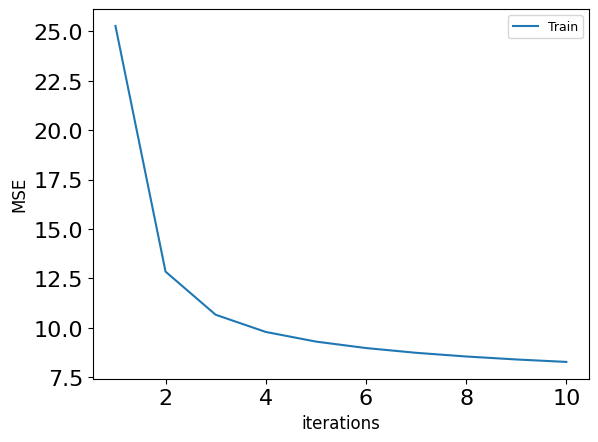

In [223]:
# print( np.array(mf.train_mse_at_epochs)[:,1] )
# mf.plot_learning_curve(validation=True)
mf.plot_learning_curve(validation=None)

In [ ]:
# help = np.zeros((mf.P.shape[0], mf.Q.T.shape[1]))
# print(np.shape(help))

# for i in range(mf.P.shape[0]):
#        for j in range(mf.Q.T.shape[1]):
#               for k in range(mf.k):
#                      help[i][j] += mf.P[i][k] * mf.Q.T[k][j]

# print(help)

In [84]:
# help2 = mf.P @ mf.Q.T
print(mf.P,"\n\n\n\n", mf.Q)

[[0.64097652 0.81445084 0.50816506 ... 0.79183397 0.88573296 0.29639769]
 [0.81819179 1.43911481 0.76782272 ... 0.93953074 0.90698471 0.67049783]
 [0.46768566 0.83350486 0.72810256 ... 0.88206096 0.83578143 0.90009087]
 ...
 [0.02789206 0.87064953 0.01057161 ... 0.42721098 0.3386313  1.09833671]
 [1.18448325 0.31793441 0.59854647 ... 0.75894204 0.67857728 0.94034587]
 [0.76909415 0.60740241 0.6678389  ... 0.95757274 0.86713029 0.544421  ]] 



 [[0.88105647 0.32218538 1.03716174 ... 0.25000874 0.40175541 0.07859848]
 [0.23276371 0.43378731 0.45605363 ... 0.29271171 0.60647119 0.48138692]
 [0.36089094 0.26952669 0.51511856 ... 0.55837359 1.36594245 0.43949882]
 ...
 [0.61211538 0.18337519 0.8626645  ... 0.29695985 0.83776925 0.27549677]
 [0.18773088 0.94658377 0.81863825 ... 0.38696764 0.19148674 0.58730196]
 [0.50225012 0.96257021 0.35507013 ... 0.50855224 0.42503991 0.23540146]]


In [63]:
train.todense()

matrix([[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [4. , 4. , 4. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [2.5, 2. , 0. , ..., 0. , 0. , 0. ],
        [3. , 0. , 0. , ..., 0. , 0. , 0. ],
        [5. , 0. , 0. , ..., 3.5, 3.5, 0. ]])

In [236]:
predictions = mf.P.dot(mf.Q.T)
mask = np.zeros_like(train.toarray())
print(type(predictions.toarray()), type(train.toarray()), train.toarray().nonzero())
mask[train.toarray().nonzero()] = 1

# Mask out unknown ratings as 0 for ease of comparison.
print(np.round(predictions.toarray() * mask, 2), "\n")
print(np.round(predictions.toarray(), 2) )
######--------
# predictions = mf.P.dot(mf.Q.T)
# mask = np.zeros_like(train)
# print(type(predictions.toarray()), type(train.toarray()), train.toarray().nonzero())
# mask[train.nonzero()] = 1

# # Mask out unknown ratings as 0 for ease of comparison.
# print(np.round(predictions * mask, 2))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> (array([  1,   1,   1, ..., 610, 610, 610]), array([   0,    1,    2, ..., 9721, 9722, 9723]))
[[ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.89  0.87  1.09 ... -0.   -0.    0.  ]
 [ 0.    0.    0.   ... -0.   -0.    0.  ]
 ...
 [ 0.98  1.01  0.   ... -0.   -0.    0.  ]
 [ 1.07  0.    0.   ...  0.    0.    0.  ]
 [ 0.95 -0.    0.   ...  0.92  0.92  0.  ]] 

[[ 0.    0.    0.   ...  0.    0.    0.  ]
 [ 0.89  0.87  1.09 ... -0.01 -0.01  0.  ]
 [ 0.65  0.1   0.05 ... -0.05 -0.05  0.  ]
 ...
 [ 0.98  1.01  0.94 ... -0.06 -0.06  0.  ]
 [ 1.07  0.27  0.44 ...  0.04  0.04  0.  ]
 [ 0.95 -0.22  1.25 ...  0.92  0.92  0.  ]]


In [ ]:
##### File saving and download utility for Colab

# from google.colab import files

# user_emb_df = pd.DataFrame(P)
# user_emb_df.to_csv("saved_user_emb.csv", delimiter="\t", index=True)
# movie_emb_df = pd.DataFrame(Q)
# movie_emb_df.to_csv("saved_movie_emb.csv", delimiter="\t", index=True)

# files.download("saved_user_emb.csv")
# files.download("saved_movie_emb.csv")